# Introducción.

La cátedra de Teoría de la Información ha proporcionado cuatro datasets analizando algo tan simple —y, paradójicamente, tan geopolíticamente condicionado por mapas y climas— como las temperaturas promedio de tres ciudades con condiciones meteorológicas (y políticas) bien distintas.

Previo al análisis de los datos, se realizará la importación de las librerías a usar, la carga de los datos y su limpieza.

## Importación de Librerías.

Se importaron las librerías necesarias que se utilizarán a lo largo del trabajo:

In [93]:
# Utilizada para la obtención de valores aleatorios.
import random

# Utilizada en la lectura de los datos.
import pandas as pd

# Utilizada en la creación de matrices.
import numpy as np

# Utilizadas para la visualización de los datos.
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

## Carga de los Datos.

Se realizó la lectura y carga de los datasets:

In [2]:
# Datasets correspondientes a las temperaturas de Quito, Melbourne y Oslo, mencionados en la explicación.
dataset_raw_quito=pd.read_csv("temperature_Quito_celsius.csv")
dataset_raw_melbourne=pd.read_csv("temperature_Melbourne_celsius.csv")
dataset_raw_oslo=pd.read_csv("temperature_Oslo_celsius.csv")

# (Este dataset será usado recién en la parte 4).
dataset_raw_melbourne_ruidoso = pd.read_csv("temperature_Melbourne_celsius_ruidoso.csv")

## Limpieza de los Datos.

Se identificaron outliers en los datasets de Melbourne y Oslo:

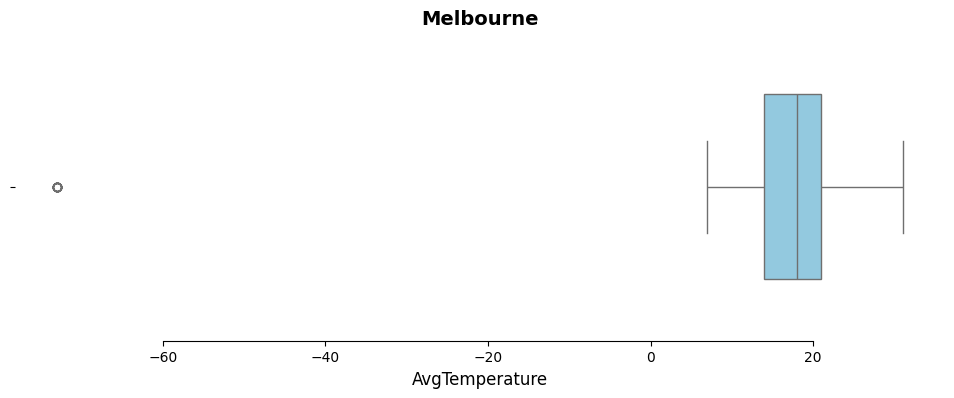

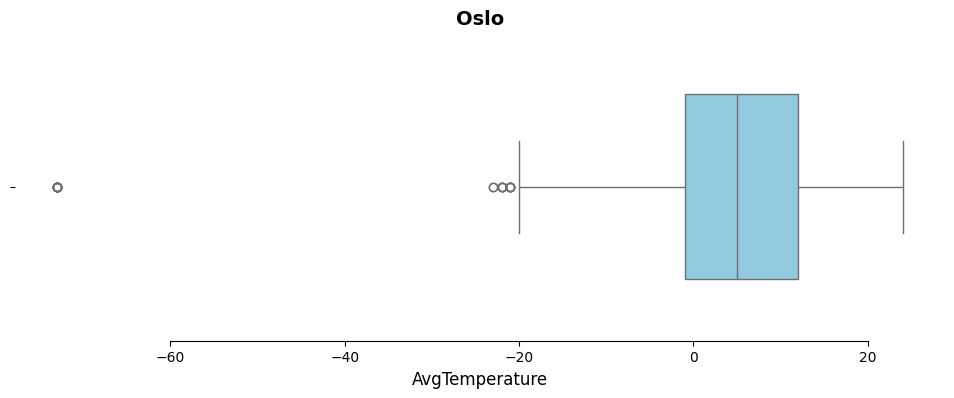

In [117]:
def mostrar_boxplot(dataset, x, title):
    plt.figure(figsize=(12, 4))
    sns.boxplot(x=dataset[x], color='skyblue', width=0.6)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel(x, fontsize=12)
    sns.despine(offset=0, trim=True)
    plt.show()

mostrar_boxplot(dataset_raw_melbourne, "AvgTemperature", "Melbourne")
mostrar_boxplot(dataset_raw_oslo, "AvgTemperature", "Oslo")

En ambos dataset, el valor de los outliers es el mismo: -73. Al momento de manejar este dato, se evaluaron distintas alternativas, tales como:

- Eliminar todas las entradas del dataset en las que aparezca dicha temperatura. Sin embargo, esto implicaría, para mantener consistencia, eliminar dichos días también de los demás datasets. Y, al estar realizadas las mediciones por días, perderlas dificultaría la toma de estadísticas entre años.

- "Reparar" los datos, a partir de sus datos vecinos. En la mayoría de las ocasiones en las que aparece un -73, lo hace entre dos valores cercanos, por ejemplo:

Cabe mencionar que los otros outliers que se presentan en los datos de Oslo no se evidencian como datos sucios. Son valores inusuales pero reales.

In [4]:
# Mostrar aparición de -73 entre datos cercanos.

Se obtienen los índices de los registros con temperatura de -73.0 C°.

In [5]:
def get_indexes_outliers(dataset, min_range, max_range=None):

    # Si no se especifica un max_range, se usa un valor exacto.
    if max_range is None:
        return list(dataset[dataset["AvgTemperature"] == min_range].index)
    
    # Se busca por rangos.
    return list(dataset[(dataset["AvgTemperature"] >= min_range) & 
                       (dataset["AvgTemperature"] <= max_range)].index)

datos_basura_melbourne = get_indexes_outliers(dataset_raw_melbourne, -73.0)
datos_basura_oslo = get_indexes_outliers(dataset_raw_oslo, -73.0)
datos_basura_melbourne_ruidoso = get_indexes_outliers(dataset_raw_melbourne_ruidoso, -77.0, -68.0)

print("Indices de datos basura: ")
print(datos_basura_melbourne)
print(datos_basura_oslo)
print(datos_basura_melbourne_ruidoso)

Indices de datos basura: 
[1453, 1454, 1459, 1460, 1470, 2246, 2725, 2726, 2727, 2728, 2806, 2981, 3187, 4622, 4790, 5015, 5212]
[1453, 1454, 1459, 1460, 1470, 2725, 2726, 2727, 2728, 4622, 4723, 5212]
[1453, 1454, 1459, 1460, 1470, 2246, 2725, 2726, 2727, 2728, 2806, 2981, 3187, 4622, 4790, 5015, 5212]


Entonces, la idea es completar ese dato a partir de los datos vecinos, calculando el promedio entre el vecino no outlier más cercano a izquierda y el más cercano a derecha. Con este propósito, se realizó una imputación por media móvil de orden 5:

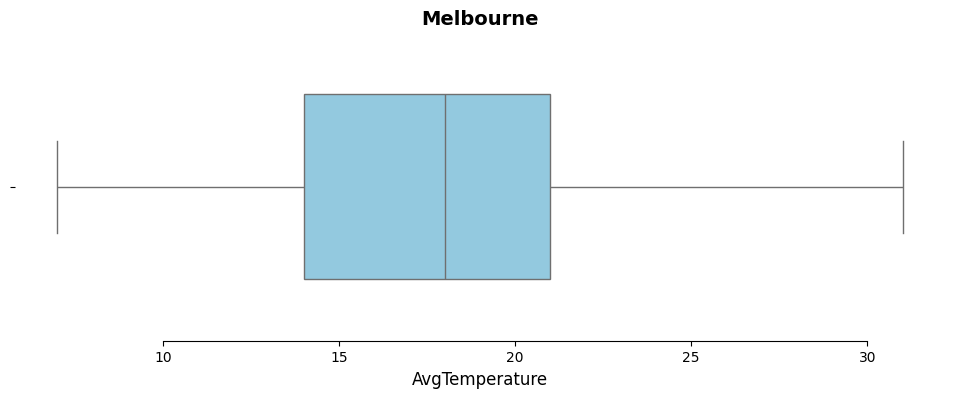

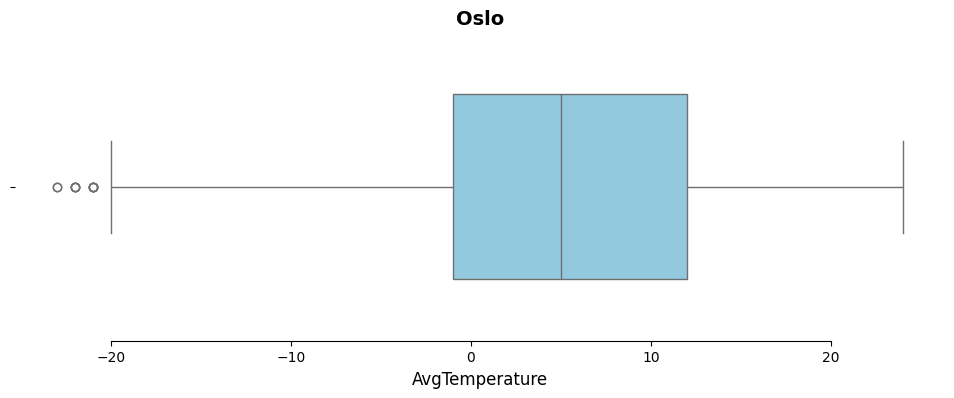

In [120]:
def imputar_dataset(indexes, dataset, orden=5):
    # Se realiza una copia para no modificar el dataset original.
    out = dataset.copy()
    for index in indexes:
        if index >= orden:
            out["AvgTemperature"][index] = round(out["AvgTemperature"][index - orden:index].mean())
    return out

cleaned_dataset_quito = dataset_raw_quito.copy() # Se redefine el nombre para mayor claridad.
cleaned_dataset_melbourne = imputar_dataset(datos_basura_melbourne, dataset_raw_melbourne)
cleaned_dataset_oslo = imputar_dataset(datos_basura_oslo, dataset_raw_oslo)
cleaned_dataset_melbourne_ruidoso = imputar_dataset(datos_basura_melbourne_ruidoso, dataset_raw_melbourne_ruidoso)

# Se observan nuevamente los boxplots con la finalidad de corroborar la limpieza de los datos.
mostrar_boxplot(cleaned_dataset_melbourne, "AvgTemperature", "Melbourne")
mostrar_boxplot(cleaned_dataset_oslo, "AvgTemperature", "Oslo")

Haciendo comprobado que los datos están limpios, se prosiguió con la resolución del trabajo práctico.

# Parte 1: Estadísticas para ingenieros que miran el cielo.

Dadas las señales de temperaturas diarias registradas durante cierto periodo en las tres ciudades (S1: Quito, S2: Melbourne, S3: Oslo), expresadas como valores enteros, en °C (grados centígrados):

## 1.1 Calcular la temperatura promedio y la desviación estándar para cada señal Si y analizar cómo se comportan estadísticamente.

Aproximadamente 16 años.

In [7]:
#Se obtiene, para cada dataset, una tabla con las temperaturas, su frecuencia y su probabilidad
def get_probabilistic_dataset(dataset):
    out = dataset["AvgTemperature"].value_counts().to_frame().reset_index()
    out.columns = ["AvgTemperature", "count"]
    out["probabilidad"] = (out["count"]/out["count"].sum())
    return out

temperaturas_melbourne=(cleaned_dataset_melbourne["AvgTemperature"].value_counts()).to_frame().reset_index()
temperaturas_melbourne.columns = ["AvgTemperature", "count"]
temperaturas_melbourne["probabilidad"] = (temperaturas_melbourne["count"]/temperaturas_melbourne["count"].sum())

temperaturas_oslo=cleaned_dataset_oslo["AvgTemperature"].value_counts().to_frame().reset_index()
temperaturas_oslo.columns = ["AvgTemperature", "count"]
temperaturas_oslo["probabilidad"] = (temperaturas_oslo["count"]/temperaturas_oslo["count"].sum())

temperaturas_quito=dataset_raw_quito["AvgTemperature"].value_counts().to_frame().reset_index()
temperaturas_quito.columns = ["AvgTemperature", "count"]
temperaturas_quito["probabilidad"] = (temperaturas_quito["count"]/temperaturas_quito["count"].sum())

In [8]:
def calcular_promedio(dataset):
    sum = 0
    for temperature in dataset["AvgTemperature"]:
        sum = sum + temperature
    return sum / len(dataset["AvgTemperature"])

In [9]:
def calcular_prom(dataset):
    sum = 0
    for temperature in dataset["AvgTemperature"]:
        sum = sum + (temperature *temperaturas_melbourne[temperaturas_melbourne["AvgTemperature"] == temperature]["probabilidad"].values[0])
    return sum

Promedios de cada ciudad:

In [10]:
promedio_melbourne = calcular_promedio(cleaned_dataset_melbourne)
prom = calcular_prom(temperaturas_melbourne)
promedio_oslo = calcular_promedio(cleaned_dataset_oslo)
promedio_quito = calcular_promedio(dataset_raw_quito)

print(promedio_melbourne)
print(prom)
print(promedio_oslo)
print(promedio_quito)

17.802874743326488
17.802874743326488
4.771218343600274
13.603524982888432


In [11]:
def calcular_desvio_estandar(dataset,promedio):
    sum = 0
    for temperature in dataset["AvgTemperature"]:
        sum += pow(temperature - promedio,2)
    return np.sqrt(sum/len(dataset["AvgTemperature"]-1)) 

In [12]:
desvio_quito = calcular_desvio_estandar(dataset_raw_quito, promedio_quito)
desvio_melbourne = calcular_desvio_estandar(cleaned_dataset_melbourne, promedio_melbourne)
desvio_oslo = calcular_desvio_estandar(cleaned_dataset_oslo, promedio_oslo)

print(desvio_quito)
print(desvio_melbourne)
print(desvio_oslo)

1.3015790563505123
4.252247296173523
8.790133528833438


Quito: Donde la temperatura no cambia ni aunque recen diez climas distintos.
Melbourne: Donde podés experimentar las cuatro estaciones antes del almuerzo.
Oslo: Donde el clima no se decide si quiere ser Siberia o un spa nórdico.

Siberia -> Temperaturas extremadamente bajas, mucha nieve.

## 1.2 Calcular el factor de correlación cruzada entre cada par de señales. Discutir si existen correlaciones significativas o no (tratando de establecer, por ejemplo, si Melbourne podría estar prediciendo el clima de Quito, o de Oslo.. o si no tienen nada que ver).

In [13]:
# Se obtiene el dataset conjunto de las temperaturas de dos ciudades, junto con la frecuencia del par
def obtener_dataset_conjunto(dataset1, dataset2):
    resultado = pd.DataFrame({
        "temperaturas_ciudad1": dataset1["AvgTemperature"].values,
        "temperaturas_ciudad2": dataset2["AvgTemperature"].values
    }).value_counts().to_frame().reset_index()
    resultado.columns = ["temperaturas_ciudad1", "temperaturas_ciudad2", "frecuencia"]
    return resultado

In [14]:
def obtener_probabilidad_conjunta(primer_temperatura, segunda_temperatura, dataset):

    filtro = (
        (dataset["temperaturas_ciudad1"] == primer_temperatura) &
        (dataset["temperaturas_ciudad2"] == segunda_temperatura)
    )

    resultado = dataset[filtro]["frecuencia"] / dataset["frecuencia"].sum()

    if (len(resultado) == 0):
        return 0
    else:
        return resultado.values[0]

In [63]:
def obtener_dataset_combinado(first_dataset, second_dataset):

    # Se crea un dataset que una, día a día, los valores de cada ciudad.
    out = pd.DataFrame({
        "temperaturas_ciudad1": first_dataset["AvgTemperature"].values,
        "temperaturas_ciudad2": second_dataset["AvgTemperature"].values
    })

    # Se definen los nombres de las columnas.
    out.columns = ["temperature_first_city", "temperature_second_city"]

    # Se agrega una columna con las frecuencias de cada aparición.
    return out.value_counts().to_frame(name="frequency").reset_index()

def obtener_conjunta(dataset_combinado):

    nro_combinaciones = dataset_combinado["frequency"].sum()

    valores_primer_dataset = dataset_combinado["temperature_first_city"].unique()
    valores_segundo_dataset = dataset_combinado["temperature_second_city"].unique()

    # Matriz de NxM, llena de ceros.
    out = np.zeros((len(valores_primer_dataset), len(valores_segundo_dataset)))

    for i in range(len(valores_primer_dataset)):
        for j in range(len(valores_segundo_dataset)):
            filtro = dataset_combinado[
                (dataset_combinado["temperature_first_city"] == valores_primer_dataset[i]) &
                (dataset_combinado["temperature_second_city"] == valores_segundo_dataset[j])
            ]
        
            if not filtro.empty:
                out[i][j] = filtro["frequency"].values[0] / nro_combinaciones
            else:
                out[i][j] = 0  # No hay combinación: frecuencia = 0

    return out

quito_melbourne_dataset = obtener_dataset_combinado(cleaned_dataset_quito, cleaned_dataset_melbourne)
quito_oslo_dataset = obtener_dataset_combinado(cleaned_dataset_quito, cleaned_dataset_oslo)
melbourne_oslo_dataset = obtener_dataset_combinado(cleaned_dataset_melbourne, cleaned_dataset_oslo)

conjunta_quito_melbourne = obtener_conjunta(quito_melbourne_dataset)
conjunta_quito_oslo = obtener_conjunta(quito_oslo_dataset)
conjunta_melbourne_oslo = obtener_conjunta(melbourne_oslo_dataset)

print(conjunta_quito_melbourne)
print(conjunta_quito_oslo)
print(conjunta_melbourne_oslo)

[[0.0261807  0.02498289 0.02310062 0.01984942 0.02190281 0.01830938
  0.020705   0.01933607 0.01865161 0.01950719 0.01676934 0.01608487
  0.0119781  0.01146475 0.00752909 0.00581793 0.0032512  0.00205339
  0.00102669 0.00017112 0.00034223 0.00034223 0.         0.
  0.        ]
 [0.01865161 0.02190281 0.02429843 0.02275838 0.02258727 0.02207392
  0.02104723 0.01984942 0.01984942 0.01865161 0.0142026  0.01608487
  0.00821355 0.01043806 0.00616016 0.00496235 0.00393566 0.00154004
  0.00154004 0.00051335 0.00051335 0.00017112 0.         0.
  0.        ]
 [0.0152293  0.0152293  0.00992471 0.01043806 0.01146475 0.01180698
  0.01060917 0.01214921 0.01009582 0.01351814 0.01129363 0.01026694
  0.00752909 0.00855578 0.00462012 0.00598905 0.00308008 0.00051335
  0.00119781 0.00085558 0.         0.00034223 0.00034223 0.00017112
  0.        ]
 [0.01112252 0.00992471 0.0142026  0.01078029 0.00924025 0.00958248
  0.00821355 0.00770021 0.01078029 0.00941136 0.01129363 0.01009582
  0.00444901 0.0068446

<img src="image-20250611-104115.png" width="" align="" />

La correlación cruzada, en términos generales, es una medida de la similitud entre dos señales o procesos, considerando un posible desfase temporal entre ellos. Se utiliza para identificar si hay una relación entre dos señales y, en caso afirmativo, determinar el grado de esa relación y el tiempo de desfase

El coeficiente de correlación cruzada (o simplemente correlación cruzada) es una medida estadística que cuantifica la similitud entre dos series temporales o señales. Indica la fuerza y dirección de la relación entre ellas, incluyendo un desfase temporal (retardo). Varía entre -1 y +1, donde -1 indica una correlación negativa perfecta, 0 ninguna correlación y +1 una correlación positiva perfecta. 

<img src="image-20250614-152550.png" width="" align="" />

# Parte 2: Una fuente de calor… markoviana.

Considerando los valores de temperatura t que componen cada señal Si, construir una nueva señal Ti compuesta por una secuencia de símbolos discretos F, T o C, definidos según: 

- F (frío): si t < 11°C

- T (templado): si 11 ≤ t < 19°C

- C (cálido): si t ≥ 19°C

Para cada Ti:

- Modelar la fuente con memoria de orden 1 (Markov), obtener la matriz de transición y analizar su comportamiento (por ejemplo, tratá de descubrir cosas como: En Oslo, si hace frío hoy, es casi seguro que siga así hasta julio..)

- Usar muestreo Monte Carlo para obtener, para cada símbolo:

- La probabilidad estacionaria (esa a la que llegás después de mucho simular).

- El tiempo medio de 1° recurrencia (ese que te dice, en promedio, cuánto tarda un símbolo en volver a aparecer después de haberse emitido).
Nota: Experimentar con diferentes umbrales de convergencia ε (comentar si realmente influyen en los resultados, o todo es una ilusión matemática). Analizar precisión de resultados en función del tiempo e incluir gráfico de convergencia.

Se discretizan las fuentes de las tres ciudades:

In [126]:
def obtener_fuente_discreta(dataset):
    # Se realiza un remplazo de los valores de temperatura por los correspondientes simbolos.
    return dataset.map(lambda x: 'F' if x < 11.0 else 'T' if x < 19.0 else 'C')

# Se obtienen los datasets discretos para cada ciudad.
discrete_quito_dataset = obtener_fuente_discreta(dataset_raw_quito)
discrete_melbourne_dataset = obtener_fuente_discreta(cleaned_dataset_melbourne)
discrete_oslo_dataset = obtener_fuente_discreta(cleaned_dataset_oslo)

# Se define dos constantes:
# - el número de símbolos en las fuentes;
NRO_SIMBOLOS = 3
# - y un diccionario que permita obtener el índice correspondiente a
#   cada simbolo dentro de las estructuras que se creen.
INDEX = {
    'F': 0,
    'T': 1,
    'C': 2
}

Se calculan las matrices de transición para cada ciudad:

In [138]:
def get_matriz_transicion(secuencia):

    # Se crea una matriz de ceros.
    matriz_transicion = np.zeros((NRO_SIMBOLOS, NRO_SIMBOLOS))

    # Se calcula la matriz de transición.
    simbolo = secuencia[0]
    for siguiente_simbolo in secuencia[1:]:
        # Se suma 1 a las apariciones de "siguiente_simbolo", dado que anteriormente salio "simbolo".
        matriz_transicion[INDEX[siguiente_simbolo], INDEX[simbolo]] += 1
        simbolo = siguiente_simbolo

    # Se divide cada celda de la matriz de transición por la cantidad de símbolos emitidos.
    suma_columnas = matriz_transicion.sum(axis=0)
    for j in range(NRO_SIMBOLOS):
        # La suma de las columnas debe dar uno.
        # Se normaliza por columna.
        if suma_columnas[j] > 0:
            # Se divide toda la columna por la cantidad de apariciones de un símbolo luego del de la columna.
            matriz_transicion[:, j] = matriz_transicion[:, j] / suma_columnas[j]

    return matriz_transicion

# Matriz de transición de Quito.
matriz_transicion_quito = get_matriz_transicion(discrete_quito_dataset["AvgTemperature"])
print("Matriz de transición de Quito:\n", matriz_transicion_quito)

# Matriz de transición de Melbourne.
matriz_transicion_melbourne = get_matriz_transicion(discrete_melbourne_dataset["AvgTemperature"])
print("\nMatriz de transición de Melbourne:\n", matriz_transicion_melbourne)

# Matriz de transición de Oslo.
matriz_transicion_oslo = get_matriz_transicion(discrete_oslo_dataset["AvgTemperature"])
print("\nMatriz de transición de Oslo:\n", matriz_transicion_oslo)

Matriz de transición de Quito:
 [[5.40540541e-02 6.03240262e-03 0.00000000e+00]
 [9.45945946e-01 9.93278180e-01 1.00000000e+00]
 [0.00000000e+00 6.89417442e-04 0.00000000e+00]]

Matriz de transición de Melbourne:
 [[0.4863388  0.0317246  0.        ]
 [0.5136612  0.83665204 0.14460512]
 [0.         0.13162335 0.85539488]]

Matriz de transición de Oslo:
 [[0.95927036 0.09908815 0.        ]
 [0.04072964 0.8656535  0.29591837]
 [0.         0.03525836 0.70408163]]


"Quito, donde la temperatura no cambia ni aunque recen diez climas distintos."

Cálculo del vector estacionario:

In [150]:
##### CÁLCULO DE LA MATRIZ ACUMULADA.
def get_matriz_acumulada(matriz_transicion):

    # Se realiza una copia de la matriz de transición, para no modificar la original.
    out = matriz_transicion.copy()

    for i in range(NRO_SIMBOLOS-1): # -1, ya que se empieza a sumar desde la segunda columna.
        for j in range(NRO_SIMBOLOS):
            # Se le suma a cada fila los valores de las filas anteriores.
            out[i+1][j] += out[i][j]

    return out

# Obtención de las matrices acumuladas para cada ciudad.
matriz_acumulada_quito = get_matriz_acumulada(matriz_transicion_quito)
matriz_acumulada_melbourne = get_matriz_acumulada(matriz_transicion_melbourne)
matriz_acumulada_oslo = get_matriz_acumulada(matriz_transicion_oslo)

##### CÁLCULO DEL VECTOR ESTACIONARIO.

def get_siguiente(simbolo_anterior, nro_simbolos, matriz_transicion_acumulada):
    
    # Se retorna un símbolo aleatorio.
    if simbolo_anterior is None:
        return random.randint(0, nro_simbolos - 1)

    p = random.random()

    for i in range(nro_simbolos):
        if (p < matriz_transicion_acumulada[i, simbolo_anterior]):
            return i

    return None

def converge(probabilidad_actual, probabilidad_anterior, epsilon):

    for i in range(len(probabilidad_actual)):
        if (abs(probabilidad_actual[i] - probabilidad_anterior[i]) > epsilon):
            return False

    return True

def mostrar_grafico_convergencia(nro_simbolos, iteraciones, historial):
    for i in range(nro_simbolos):
        plt.plot(range(0, iteraciones, 100), historial[i], label=f'Símbolo {i}')
    plt.xlabel('Iteraciones')
    plt.ylabel('Probabilidad')
    plt.title('Convergencia del vector estacionario')
    plt.legend()
    plt.grid(True)
    plt.show()

def get_vector_estacionario(matriz_transicion_acumulada, nro_simbolos, epsilon=0.0000005, min_iteraciones=100000):

    apariciones = np.zeros(nro_simbolos)
    vector_estacionario = np.zeros(nro_simbolos)
    vector_estacionario_anterior = np.full(nro_simbolos, -1)
    simbolo_anterior = None
    iteraciones = 0

    # Se guarda el historial para graficar.
    historial = [[] for _ in range(nro_simbolos)]

    while (not converge(vector_estacionario, vector_estacionario_anterior, epsilon) or (iteraciones < min_iteraciones)):

        simbolo = get_siguiente(simbolo_anterior, nro_simbolos, matriz_transicion_acumulada)
        iteraciones += 1

        apariciones[simbolo] += 1
        vector_estacionario_anterior = vector_estacionario.copy()
        vector_estacionario = np.array([ aparicion / iteraciones for aparicion in apariciones ])

        # Cada 100 iteraciones, se añade a cada símbolo la probabilidad hallada.
        # Esto con fines de poder realizar el diagrama de convergencia.
        if iteraciones % 100 == 0:
            for i in range(nro_simbolos):
                historial[i].append(vector_estacionario[i])

        simbolo_anterior = simbolo

    return vector_estacionario.round(3), historial

def analizar_resultados(matriz_transicion_acumulada):
    print("Matriz de transición acumulada:")
    print(matriz_transicion_acumulada)
    vector_estacionario, historial = get_vector_estacionario(matriz_transicion_acumulada, 3)
    print("\nVector estacionario:\n", vector_estacionario,"\n")
    #mostrar_grafico_convergencia(3, 100000, historial) ARREGLAR

vector_estacionario_quito, historial = get_vector_estacionario(matriz_acumulada_quito, 3)
vector_estacionario_melbourne, historial = get_vector_estacionario(matriz_acumulada_melbourne, 3)
vector_estacionario_oslo, historial = get_vector_estacionario(matriz_acumulada_oslo, 3)

print("Quito:")
analizar_resultados(matriz_acumulada_quito)
print("Melbourne:")
analizar_resultados(matriz_acumulada_melbourne)
print("Oslo:")
analizar_resultados(matriz_acumulada_oslo)


Quito:
Matriz de transición acumulada:
[[0.05405405 0.0060324  0.        ]
 [1.         0.99931058 1.        ]
 [1.         1.         1.        ]]

Vector estacionario:
 [0.006 0.993 0.001] 

Melbourne:
Matriz de transición acumulada:
[[0.4863388  0.0317246  0.        ]
 [1.         0.86837665 0.14460512]
 [1.         1.         1.        ]]

Vector estacionario:
 [0.032 0.507 0.461] 

Oslo:
Matriz de transición acumulada:
[[0.95927036 0.09908815 0.        ]
 [1.         0.96474164 0.29591837]
 [1.         1.         1.        ]]

Vector estacionario:
 [0.685 0.281 0.034] 



### El tiempo medio de 1° recurrencia.

In [20]:
def obtener_medias_primera_recurrencia(matriz_transicion_acumulada, nro_simbolos, epsilon=0.0005, min_iteraciones=100000):
    
    pasos = [0] * nro_simbolos # np.zeros(nro_simbolos)
    ocurrencias = [0] * nro_simbolos # np.zeros(nro_simbolos)
    medias_recurrencia = [0] * nro_simbolos # np.zeros(nro_simbolos)
    t_ultima_ocurrencia = [-1] * nro_simbolos # np.full(nro_simbolos, -1)
    medias_recurrencia_anterior = [-1] * nro_simbolos # np.full(nro_simbolos, -1)
    
    t_actual = 0

    simbolo = None
	
    while (not converge(medias_recurrencia, medias_recurrencia_anterior, epsilon) or (t_actual < min_iteraciones)):

        simbolo = get_siguiente(simbolo, nro_simbolos, matriz_transicion_acumulada)

        # Si la señal ya apareció al menos una vez...
        if (t_ultima_ocurrencia[simbolo] >= 0):
            # Se suma la cantidad de pasos desde la última ocurrencia.
            pasos[simbolo] += t_actual - t_ultima_ocurrencia[simbolo]
            ocurrencias[simbolo] += 1

        t_ultima_ocurrencia[simbolo] = t_actual
        t_actual += 1

        # Se actualiza la media de primera recurrencia del símbolo.
        medias_recurrencia_anterior[simbolo] = medias_recurrencia[simbolo]
        if (ocurrencias[simbolo] > 0):
            medias_recurrencia[simbolo] = pasos[simbolo] / ocurrencias[simbolo]
        
    return [round(x,3) for x in medias_recurrencia]
	
print("Medias de primera recurrencia:")
medias_primera_recurrencia_quito = obtener_medias_primera_recurrencia(matriz_acumulada_quito, 3)
print("Quito:", medias_primera_recurrencia_quito)
medias_primera_recurrencia_melbourne = obtener_medias_primera_recurrencia(matriz_acumulada_melbourne, 3)
print("Melbourne:", medias_primera_recurrencia_melbourne)
medias_primera_recurrencia_oslo = obtener_medias_primera_recurrencia(matriz_acumulada_oslo, 3)
print("Oslo:", medias_primera_recurrencia_oslo)

Medias de primera recurrencia:
Quito: [157.414, 1.007, 1001.124]
Melbourne: [33.416, 1.964, 2.169]
Oslo: [1.46, 3.535, 30.937]


Media de recurrencia → Tiempo medio de espera para volver a emitir un símbolo.

# Parte 3: Entropía, Huffman y la batalla por los bits

## 1. Calcular la entropía de cada fuente Ti :

### a. Sin memoria (orden 0), considerando símbolos individuales.

In [21]:
def get_entropia_sin_memoria(vector_estacionario):
    nro_simbolos = len(vector_estacionario)
    h = 0
    for i in range(nro_simbolos):
        if vector_estacionario[i] != 0:
            h += vector_estacionario[i] * np.log2(vector_estacionario[i])
    return round(-h, 3)

entropia_melbourne = get_entropia_sin_memoria(vector_estacionario_melbourne)
entropia_quito = get_entropia_sin_memoria(vector_estacionario_quito)
entropia_oslo = get_entropia_sin_memoria(vector_estacionario_oslo)
print("Entropía sin memoria para Melbourne: ", entropia_melbourne)
print("Entropía sin memoria para Quito: ", entropia_quito)
print("Entropía sin memoria para Oslo: ", entropia_oslo)

Entropía sin memoria para Melbourne:  1.17
Entropía sin memoria para Quito:  0.072
Entropía sin memoria para Oslo:  1.054


### b. Con memoria (orden 1), usando información sobre transiciones entre símbolos.

In [22]:
def get_entropia_con_memoria(matriz_transicion, vector_estacionario, nro_simbolos=3):
    hcond = 0
    for i in range(nro_simbolos):
        hi = 0
        for j in range(nro_simbolos):
            if matriz_transicion[j][i] != 0:
                hi += matriz_transicion[j][i] * np.log2(matriz_transicion[j][i])
        hcond += vector_estacionario[i] * (-hi)
    return round(hcond, 3)

entropia_cond_melbourne = get_entropia_con_memoria(matriz_transicion_melbourne, vector_estacionario_melbourne)
entropia_cond_quito = get_entropia_con_memoria(matriz_transicion_quito, vector_estacionario_quito)
entropia_cond_oslo = get_entropia_con_memoria(matriz_transicion_oslo, vector_estacionario_oslo)
print("Entropía con memoria para Melbourne: ", entropia_cond_melbourne)
print("Entropía con memoria para Quito: ", entropia_cond_quito)
print("Entropía con memoria para Oslo: ", entropia_cond_oslo)

Entropía con memoria para Melbourne:  0.693
Entropía con memoria para Quito:  0.066
Entropía con memoria para Oslo:  0.39


### Interpretar los resultados: ¿Qué ciudad presenta menor entropía? ¿Cuál más? ¿Esto hace que alguna ciudad sea más impredecible que otra?

A la mayor entropía la presenta Melbourne. Con una entropía cercana, se halla Oslo. Quito tiene la menor entropía, lo cual es coherente con su descripción:

## 2. Implementar el algoritmo de Huffman para codificar cada señal Ti  y su extensión a orden 2, teniendo en cuenta que la fuente es markoviana. Aplicar el Teorema de Shannon y analizar resultados.

In [23]:
def get_fuente(vector_estacionario):
    fuente = {
        'F' : vector_estacionario[0],
        'T' : vector_estacionario[1],
        'C' : vector_estacionario[2]
    }
    return fuente

fuente_melbourne = get_fuente(vector_estacionario_melbourne)
fuente_quito = get_fuente(vector_estacionario_quito)
fuente_oslo = get_fuente(vector_estacionario_oslo)

In [24]:
def reemplazar(fuente):
    out = {}
    remplazo = {}
    letra = '@'
    for(key, value) in fuente.items():
        letra = chr(ord(letra) + 1)
        out.update({letra : value})
        remplazo.update({letra : key})
    return out , remplazo

def extender(fuente, remplazo):
    out = {}
    for(key, value) in fuente.items():
        out.update({remplazo[key] : value})
    return out

In [25]:
def get_fuente_orden2(vector_estacionario, matriz_transicion): 
    fuente = {
        0 : 'F',
        1 : 'T',
        2 : 'C'
    }
    fuente2 = {}
    for i in range(3):
        for j in range(3):
            p = vector_estacionario[i] * matriz_transicion[j][i]
            if p != 0:
                fuente2.update({fuente[i] + fuente[j] : p})
    return fuente2

orden2_melbourne_aux , remplazo_melbourne = reemplazar(get_fuente_orden2(vector_estacionario_melbourne, matriz_transicion_melbourne))
orden2_quito_aux, remplazo_quito = reemplazar(get_fuente_orden2(vector_estacionario_quito, matriz_transicion_quito))
orden2_oslo_aux, remplazo_oslo = reemplazar(get_fuente_orden2(vector_estacionario_oslo, matriz_transicion_oslo))
print("Fuente de orden 2  para Melborne: ",orden2_melbourne_aux)
print("Fuente de orden 2  para Quito: ",orden2_quito_aux)
print("Fuente de orden 2  para Oslo: ",orden2_oslo_aux)

Fuente de orden 2  para Melborne:  {'A': 0.015552, 'B': 0.016448, 'C': 0.01632, 'D': 0.42686999999999997, 'E': 0.06732, 'F': 0.06641, 'G': 0.39159}
Fuente de orden 2  para Quito:  {'A': 0.000378, 'B': 0.006621999999999999, 'C': 0.005952, 'D': 0.9850559999999999, 'E': 0.000992, 'F': 0.001}
Fuente de orden 2  para Oslo:  {'A': 0.654997, 'B': 0.028003000000000004, 'C': 0.028116, 'D': 0.24594399999999997, 'E': 0.009940000000000001, 'F': 0.009768, 'G': 0.023232}


In [26]:
def get_codificacion_huffman(fuente):
    copia = fuente.copy()
    out = {}
    prob_obtenida = 0

    # El round() es necesario puesto a que, al no trabjar con números exactos, a veces se producen errores de redondeo,
    # tal y como que la suma da 0.9999... y entonces el while itera una vez más de lo que debería.
    while prob_obtenida <= 0.99:
        copia = dict(sorted(copia.items(), key=lambda x: x[1], reverse=True))
        ultimo = list(copia.items())[-1]
        anteultimo = list(copia.items())[-2]
        for char in list(anteultimo[0]):
            out[char] = '1' + str(out.get(char,''))
        for char in list(ultimo[0]):
            out[char] = '0' + str(out.get(char,''))
        prob_obtenida = (ultimo[1] + anteultimo[1])
        del copia[ultimo[0]]
        del copia[anteultimo[0]]
        copia.update({ultimo[0] + anteultimo[0] : prob_obtenida})
    
    return out

huffman_melbourne = get_codificacion_huffman(fuente_melbourne)
huffman_quito = get_codificacion_huffman(fuente_quito)
huffman_oslo = get_codificacion_huffman(fuente_oslo)
huffman_melbourne2_aux = get_codificacion_huffman(orden2_melbourne_aux)
huffman_quito2_aux = get_codificacion_huffman(orden2_quito_aux)
huffman_oslo2_aux = get_codificacion_huffman(orden2_oslo_aux)
print("Codificación Huffman para Melbourne: ",huffman_melbourne)
print("Codificación Huffman para Quito: ",huffman_quito)
print("Codificación Huffman para Oslo: ",huffman_oslo)
print("Codificación Huffman para orden 2 de Melbourne: ",huffman_melbourne2_aux)
print("Codificación Huffman para orden 2 de Quito: ",huffman_quito2_aux)
print("Codificación Huffman para orden 2 de Oslo: ",huffman_oslo2_aux)  

Codificación Huffman para Melbourne:  {'C': '01', 'F': '00', 'T': '1'}
Codificación Huffman para Quito:  {'F': '01', 'C': '00', 'T': '1'}
Codificación Huffman para Oslo:  {'T': '01', 'C': '00', 'F': '1'}
Codificación Huffman para orden 2 de Melbourne:  {'C': '101011', 'A': '101010', 'B': '10100', 'F': '1011', 'E': '100', 'G': '11', 'D': '0'}
Codificación Huffman para orden 2 de Quito:  {'E': '01011', 'A': '01010', 'F': '0100', 'C': '011', 'B': '00', 'D': '1'}
Codificación Huffman para orden 2 de Oslo:  {'E': '00001', 'F': '00000', 'G': '0001', 'C': '0011', 'B': '0010', 'D': '01', 'A': '1'}


In [27]:
orden2_melbourne = extender(orden2_melbourne_aux, remplazo_melbourne)
orden2_quito = extender(orden2_quito_aux, remplazo_quito)
orden2_oslo = extender(orden2_oslo_aux, remplazo_oslo)

huffman_melbourne2 = extender(huffman_melbourne2_aux, remplazo_melbourne)
huffman_quito2 = extender(huffman_quito2_aux, remplazo_quito)
huffman_oslo2 = extender(huffman_oslo2_aux, remplazo_oslo)

print(huffman_quito2)

{'TC': '01011', 'FF': '01010', 'CT': '0100', 'TF': '011', 'FT': '00', 'TT': '1'}


## 3. En cada caso, calcular la longitud total del mensaje codificado (en bits), compararla con la longitud original del archivo y obtener la tasa de compresión.

In [28]:
def get_longitud_media(codigo_huffman,probabilidades):
    L = 0
    for key, value in codigo_huffman.items():
        L += len(value) * probabilidades[key]
    return L

longitud_media_melbourne = get_longitud_media(huffman_melbourne, fuente_melbourne)
longitud_media_quito = get_longitud_media(huffman_quito, fuente_quito)
longitud_media_oslo = get_longitud_media(huffman_oslo, fuente_oslo)
longitud_media_melbourne2 = get_longitud_media(huffman_melbourne2, orden2_melbourne)
longitud_media_quito2 = get_longitud_media(huffman_quito2, orden2_quito)
longitud_media_oslo2 = get_longitud_media(huffman_oslo2, orden2_oslo)
print("Longitud media para Melbourne: ",longitud_media_melbourne)
print("Longitud media para Quito: ",longitud_media_quito)
print("Longitud media para Oslo: ",longitud_media_oslo)
print("Longitud media para orden 2 de Melbourne: ",longitud_media_melbourne2)
print("Longitud media para orden 2 de Quito: ",longitud_media_quito2)
print("Longitud media para orden 2 de Oslo: ",longitud_media_oslo2)

Longitud media para Melbourne:  1.49
Longitud media para Quito:  1.008
Longitud media para Oslo:  1.317
Longitud media para orden 2 de Melbourne:  1.9511220000000002
Longitud media para orden 2 de Quito:  1.0270059999999999
Longitud media para orden 2 de Oslo:  1.562829


In [29]:
def get_limites_shannon(h,hcond,n):
    lim_inferior = h/n + ((1 - 1/n) * hcond)
    lim_superior = lim_inferior + 1/n
    return lim_inferior, lim_superior

limite_inferior_melbourne, limite_superior_melbourne = get_limites_shannon(entropia_melbourne, entropia_cond_melbourne, 1)
limite_inferior_quito, limite_superior_quito = get_limites_shannon(entropia_quito, entropia_cond_quito, 1)
limite_inferior_oslo, limite_superior_oslo = get_limites_shannon(entropia_oslo, entropia_cond_oslo, 1)
limite_inferior_melbourne2, limite_superior_melbourne2 = get_limites_shannon(entropia_melbourne, entropia_cond_melbourne, 2)
limite_inferior_quito2, limite_superior_quito2 = get_limites_shannon(entropia_quito, entropia_cond_quito, 2)
limite_inferior_oslo2, limite_superior_oslo2 = get_limites_shannon(entropia_oslo, entropia_cond_oslo, 2)
print("Shannon para Melbourne orden 1: ")
print(limite_inferior_melbourne, " <= ", longitud_media_melbourne, " < ", limite_superior_melbourne)
print("Shannon para Quito orden 1: ")
print(limite_inferior_quito, " <= ", longitud_media_quito, " < ", limite_superior_quito)
print("Shannon para Oslo orden 1: ")
print(limite_inferior_oslo, " <= ", longitud_media_oslo, " < ", limite_superior_oslo)
print("Shannon para Melbourne orden 2: ")
print(limite_inferior_melbourne2, " <= ", longitud_media_melbourne2/2, " < ", limite_superior_melbourne2)
print("Shannon para Quito orden 2: ")
print(limite_inferior_quito2, " <= ", longitud_media_quito2/2, " < ", limite_superior_quito2)
print("Shannon para Oslo orden 2: ")
print(limite_inferior_oslo2, " <= ", longitud_media_oslo2/2, " < ", limite_superior_oslo2)

Shannon para Melbourne orden 1: 
1.17  <=  1.49  <  2.17
Shannon para Quito orden 1: 
0.072  <=  1.008  <  1.072
Shannon para Oslo orden 1: 
1.054  <=  1.317  <  2.0540000000000003
Shannon para Melbourne orden 2: 
0.9315  <=  0.9755610000000001  <  1.4315
Shannon para Quito orden 2: 
0.069  <=  0.5135029999999999  <  0.569
Shannon para Oslo orden 2: 
0.722  <=  0.7814145  <  1.222


Asumiendo que los símbolos enviados originalmente son codificados

In [30]:
def get_fuente_pares(dataset_discreto):
    out = pd.DataFrame(columns = ["Par"])
    for i in range((len(dataset_discreto)//2)):
        out.loc[i] = [dataset_discreto["AvgTemperature"][i*2] + dataset_discreto["AvgTemperature"][i*2+1]]
    return out

def get_values_and_counts(dataset):
    values, counts = np.unique(dataset, return_counts=True)
    # Se retorna un diccionario que asocia a cada valor único su número de apariciones.
    return dict(zip(values, counts))

def obtener_tasa_comprension(original_dataset, discrete_dataset, huffman_codification):

    original_count = get_values_and_counts(original_dataset)
    discrete_count = get_values_and_counts(discrete_dataset)

    bits_originales = 0
    for (value, count) in original_count.items():
        # Cantidad de bits que deben usarse para almacenar el valor por su número de apariciones.
        bits_originales += len(bin(int(value))[2:]) * count

    bits_codificados = 0
    for (value, count) in discrete_count.items():
        # Cantidad de bits que deben usarse para almacenar el valor por su número de apariciones.
        bits_codificados += len(huffman_codification[value]) * count

    tasa_comprension = bits_originales / bits_codificados
    return bits_originales, bits_codificados, tasa_comprension

print("COMPRENSIONES DE ORDEN 1:")
bits_originales_melbourne, bits_codificados_melbourne, tasa_comprension_melbourne = obtener_tasa_comprension(cleaned_dataset_melbourne, discrete_melbourne_dataset["AvgTemperature"], huffman_melbourne)
bits_originales_quito, bits_codificados_quito, tasa_comprension_quito = obtener_tasa_comprension(dataset_raw_quito, discrete_quito_dataset["AvgTemperature"], huffman_quito)
bits_originales_oslo, bits_codificados_oslo, tasa_comprension_oslo = obtener_tasa_comprension(cleaned_dataset_oslo, discrete_oslo_dataset["AvgTemperature"], huffman_oslo)
print("\nTasa de comprensión para Melbourne: ",tasa_comprension_melbourne)
print(f"En lugar de utilizarse {bits_originales_melbourne} bits, se utilizan {bits_codificados_melbourne} bits.")
print("\nTasa de comprensión para Quito: ",tasa_comprension_quito)
print(f"En lugar de utilizarse {bits_originales_quito} bits, se utilizan {bits_codificados_quito} bits.")
print("\nTasa de comprensión para Oslo: ",tasa_comprension_oslo)
print(f"En lugar de utilizarse {bits_originales_oslo} bits, se utilizan {bits_codificados_oslo} bits.")

print("\nCOMPRENSIONES DE ORDEN 2:")
bits_originales_melbourne, bits_codificados_melbourne, tasa_comprension_melbourne = obtener_tasa_comprension(cleaned_dataset_melbourne, get_fuente_pares(discrete_melbourne_dataset), huffman_melbourne2)
bits_originales_quito, bits_codificados_quito, tasa_comprension_quito = obtener_tasa_comprension(dataset_raw_quito, get_fuente_pares(discrete_quito_dataset), huffman_quito2)
bits_originales_oslo, bits_codificados_oslo, tasa_comprension_oslo = obtener_tasa_comprension(cleaned_dataset_oslo, get_fuente_pares(discrete_oslo_dataset), huffman_oslo2)
print("\nTasa de comprensión para Melbourne: ",tasa_comprension_melbourne)
print(f"En lugar de utilizarse {bits_originales_melbourne} bits, se utilizan {bits_codificados_melbourne} bits.")
print("\nTasa de comprensión para Quito: ",tasa_comprension_quito)
print(f"En lugar de utilizarse {bits_originales_quito} bits, se utilizan {bits_codificados_quito} bits.")
print("\nTasa de comprensión para Oslo: ",tasa_comprension_oslo)
print(f"En lugar de utilizarse {bits_originales_oslo} bits, se utilizan {bits_codificados_oslo} bits.")

COMPRENSIONES DE ORDEN 1:

Tasa de comprensión para Melbourne:  3.1267621776504297
En lugar de utilizarse 27281 bits, se utilizan 8725 bits.

Tasa de comprensión para Quito:  4.037043330501274
En lugar de utilizarse 23758 bits, se utilizan 5885 bits.

Tasa de comprensión para Oslo:  2.6608978529603124
En lugar de utilizarse 20449 bits, se utilizan 7685 bits.

COMPRENSIONES DE ORDEN 2:

Tasa de comprensión para Melbourne:  4.773578302712161
En lugar de utilizarse 27281 bits, se utilizan 5715 bits.

Tasa de comprensión para Quito:  7.924616410940627
En lugar de utilizarse 23758 bits, se utilizan 2998 bits.

Tasa de comprensión para Oslo:  4.449303742384682
En lugar de utilizarse 20449 bits, se utilizan 4596 bits.


# Parte 4: El canal climático de Musk.

Ahora el satélite en órbita (SpaceHeat-42) transmite la señal $S_2$ (de Melbourne)… pero lo que llega a la base terrestre es S4 (Melbourne “ruidoso”), misteriosamente diferente.

In [31]:
def get_matriz_conjunta(matriz_transicion, vector_estacionario, orden=3):
    
    # Se crea una matriz cuadrada de ceros.
    out = np.zeros((orden, orden))

    for i in range(orden):
        for j in range(orden):
            out[i][j] = (matriz_transicion[i][j] * vector_estacionario[j]).round(3)

    return out

matriz_conjunta_melbourne = get_matriz_conjunta(matriz_transicion_melbourne, vector_estacionario_melbourne)
print("Matriz conjunta de Melbourne:\n", matriz_conjunta_melbourne)

Matriz conjunta de Melbourne:
 [[0.016 0.016 0.   ]
 [0.016 0.427 0.066]
 [0.    0.067 0.392]]


Ahora el satélite en órbita (SpaceHeat-42) transmite la señal S2 (de Melbourne)… pero lo que llega a la base terrestre es S4 (Melbourne “ruidoso”), misteriosamente diferente.
Generar T4 (de igual manera igual que se generaron las otras Ti), y construir la matriz de canal comparando T2 (entrada) y T4 (salida).
Calcula el Ruido del canal y la Información mutua. Analizar los valores obtenidos (explicar si es un buen canal o una porquería disfrazada de innovación).

Se obtiene la fuente discreta de T4 y se construye su matriz de transición:

In [32]:
discrete_melbourne_ruidoso_dataset = obtener_fuente_discreta(cleaned_dataset_melbourne_ruidoso)
matriz_transicion_melbourne_ruidoso = get_matriz_transicion(3, discrete_melbourne_ruidoso_dataset["AvgTemperature"])

print("Matriz de transición de Melbourne:\n", matriz_transicion_melbourne)
print("\nMatriz de transición para Melbourne ruidoso:\n", matriz_transicion_melbourne_ruidoso)

Matriz de transición de Melbourne:
 [[0.486 0.032 0.   ]
 [0.514 0.837 0.145]
 [0.    0.132 0.855]]

Matriz de transición para Melbourne ruidoso:
 [[0.303 0.12  0.012]
 [0.631 0.573 0.323]
 [0.066 0.306 0.664]]


In [33]:
def get_canal_compuesto(entrada, salida, orden=3, rounding=3):

    # Se crea una matriz llena de ceros, en la que almacenará el canal compuesto.
    out = np.zeros((orden, orden))

    for i in range(orden):
        for j in range(orden):
            suma = 0
            for k in range(orden):
                suma += salida[i][k] * entrada[k][j]
            out[i][j] = round(suma, rounding)

    return out

canal_compuesto = get_canal_compuesto(matriz_transicion_melbourne, matriz_transicion_melbourne_ruidoso)
print(canal_compuesto)

[[0.209 0.112 0.028]
 [0.601 0.542 0.359]
 [0.189 0.346 0.612]]


Se tiene un canal, donde la entrada es T2 y T4 es la salida:

In [34]:
def get_ruido(matriz_transicion, vector_estacionario):
    # Hcond = H(Y/X)
    return round(get_entropia_con_memoria(matriz_transicion, vector_estacionario), 3)

ruido_canal_compuesto = get_ruido(canal_compuesto, vector_estacionario_melbourne)
print("Ruido para Melbourne ruidoso: ", ruido_canal_compuesto)

Ruido para Melbourne ruidoso:  1.246


In [35]:
def get_distribucion_salida(matriz_conjunta, orden=3):

    # Arreglo de salida, lleno de ceros.
    out = np.zeros(orden)

    for i in range(orden):
        for j in range(orden):
            # Se suman las filas.
            out[i] += matriz_conjunta[i][j]

    return out.round(3)

# I(X,Y) = H(Y) - H(Y/X)
informacion_mutua = round(get_entropia_sin_memoria(get_distribucion_salida(get_matriz_conjunta(canal_compuesto, vector_estacionario_melbourne))) - ruido_canal_compuesto, 3)
print("Información mutua del canal compuesto: ", informacion_mutua)

Información mutua del canal compuesto:  0.069


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=1ebd8bcc-2607-4fac-b013-6f5656f47292' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>